In [1]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [39]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import re

In [62]:
df_train = pd.read_csv('/content/drive/MyDrive/2020335_2020076_Project/Dataset/archive1/train.csv',sep=',')
df_train.text=df_train.text.astype(str)
df_val = pd.read_csv('/content/drive/MyDrive/2020335_2020076_Project/Dataset/archive1/test.csv',sep=',')
df_val.text=df_val.text.astype(str)

In [63]:
df = pd.concat([df_train.assign(ind="train"),df_val.assign(ind="validation")])
df.head()

,textID,text,selected_text,sentiment,ind
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,train
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,train
2,088c60f138,my boss is bullying me...,bullying me,negative,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,train
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,train


In [64]:
df = df.loc[(df['sentiment'] == 'positive') | (df['sentiment'] == 'negative') | (df['sentiment'] == 'neutral')]
df.head()


,textID,text,selected_text,sentiment,ind
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,train
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,train
2,088c60f138,my boss is bullying me...,bullying me,negative,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,train
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,train


In [65]:
df.loc[df['sentiment'] == 'positive','sentiment'] = 1
df.loc[df['sentiment'] == 'negative','sentiment'] = 0
df.loc[df['sentiment'] == 'neutral','sentiment'] = 2
df.head()

,textID,text,selected_text,sentiment,ind
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",2,train
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0,train
2,088c60f138,my boss is bullying me...,bullying me,0,train
3,9642c003ef,what interview! leave me alone,leave me alone,0,train
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0,train


In [66]:
!pip install spacy

In [67]:
import spacy
import re

nlp = spacy.load('en_core_web_sm')

In [68]:
df["text"] = df["text"].astype(str)
df["text"] = df['text'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x) if not y.is_stop]))
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply((lambda x: re.sub('[^\w\s]','',x)))

In [69]:
max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['text'].values)

In [70]:
df.head()

,textID,text,selected_text,sentiment,ind
0,cb774db0d1,id respond go,"I`d have responded, if I were going",2,train
1,549e992a42,sooo sad miss san diego,Sooo SAD,0,train
2,088c60f138,boss bully,bullying me,0,train
3,9642c003ef,interview leave,leave me alone,0,train
4,358bd9e861,son couldnt release buy,"Sons of ****,",0,train


In [71]:
df_train, df_val = df[df["ind"].eq("train")], df[df["ind"].eq("validation")]

In [72]:
X_train = tokenizer.texts_to_sequences(df_train['text'].values)
X_train = pad_sequences(X_train)
X_val = tokenizer.texts_to_sequences(df_val['text'].values)
X_val = pad_sequences(X_val)

In [73]:
X_train

array([[   0,    0,    0, ...,  220, 1140,    3],
       [   0,    0,    0, ...,   18, 1104, 1823],
       [   0,    0,    0, ...,    0,    0, 1027],
       ...,
       [   0,    0,    0, ...,  384,  619, 2189],
       [   0,    0,    0, ...,    0,    0,  508],
       [   0,    0,    0, ...,  456,  130,  324]], dtype=int32)

In [74]:
[X_train.shape,X_val.shape]

[(27481, 21), (3534, 18)]

In [75]:
X_val = np.lib.pad(X_val, ((0,0),(X_train.shape[1] - X_val.shape[1],0)), 'constant', constant_values=(0))
X_val.shape

(3534, 21)

In [76]:
X_val

array([[   0,    0,    0, ...,    0,  842,    1],
       [   0,    0,    0, ...,    4, 1129, 1783],
       [   0,    0,    0, ..., 1061,  623,  568],
       ...,
       [   0,    0,    0, ...,  266, 1985,   17],
       [   0,    0,    0, ...,   37,    8,  238],
       [   0,    0,    0, ...,  231, 2424, 2836]], dtype=int32)

In [77]:
Y_train = np.array(pd.get_dummies((df_train['sentiment']).values))
Y_val = np.array(pd.get_dummies((df_val['sentiment']).values))

<ipython-input-77-7282a98543d3>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  Y_train = np.array(pd.get_dummies((df_train['sentiment']).values))
<ipython-input-77-7282a98543d3>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  Y_val = np.array(pd.get_dummies((df_val['sentiment']).values))


In [78]:
Y_val

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

In [79]:
max_features = 3000
embed_dim = 128
lstm_out = 256


In [80]:
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(3,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 21, 128)           384000    
                                                                 
 spatial_dropout1d_7 (Spati  (None, 21, 128)           0         
 alDropout1D)                                                    
                                                                 
 lstm_7 (LSTM)               (None, 256)               394240    
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 779011 (2.97 MB)
Trainable params: 779011 (2.97 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [81]:
from keras.callbacks import EarlyStopping


batch_size = 64

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, Y_train, epochs = 30, batch_size=batch_size, verbose = 2, shuffle=False,
          validation_data=(X_val, Y_val),
          callbacks=[early_stopping])

Epoch 1/30
430/430 - 43s - loss: 0.8336 - accuracy: 0.6227 - val_loss: 0.7046 - val_accuracy: 0.6902 - 43s/epoch - 101ms/step
Epoch 2/30
430/430 - 31s - loss: 0.6777 - accuracy: 0.7212 - val_loss: 0.6703 - val_accuracy: 0.7204 - 31s/epoch - 72ms/step
Epoch 3/30
430/430 - 32s - loss: 0.6312 - accuracy: 0.7467 - val_loss: 0.6535 - val_accuracy: 0.7349 - 32s/epoch - 75ms/step
Epoch 4/30
430/430 - 33s - loss: 0.6053 - accuracy: 0.7581 - val_loss: 0.6548 - val_accuracy: 0.7306 - 33s/epoch - 77ms/step
Epoch 5/30
430/430 - 32s - loss: 0.5880 - accuracy: 0.7647 - val_loss: 0.6620 - val_accuracy: 0.7286 - 32s/epoch - 74ms/step
Epoch 6/30
430/430 - 32s - loss: 0.5713 - accuracy: 0.7740 - val_loss: 0.6706 - val_accuracy: 0.7255 - 32s/epoch - 74ms/step
Epoch 7/30
430/430 - 32s - loss: 0.5498 - accuracy: 0.7822 - val_loss: 0.6817 - val_accuracy: 0.7289 - 32s/epoch - 74ms/step
Epoch 8/30
430/430 - 33s - loss: 0.5327 - accuracy: 0.7896 - val_loss: 0.7057 - val_accuracy: 0.7252 - 33s/epoch - 76ms/step

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import numpy as np




def evaluate_lstm(model, X_test, Y_test):
    pos_correct, neg_correct = 0, 0
    results = []

    for x in range(len(X_test)):
        result = model.predict(X_test[x].reshape(1, X_test.shape[1]), batch_size=1, verbose=3)[0]

        if np.argmax(result) == np.argmax(Y_test[x]):
            if np.argmax(Y_test[x]) == 0:
                neg_correct += 1
            else:
                pos_correct += 1

        results.append(np.argmax(result))

    Y_test_argmax = np.argmax(Y_test, axis=1)
    results = np.asarray(results)

    conf_matrix = confusion_matrix(Y_test_argmax, results)

    fig = plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='GnBu')
    plt.title("Confusion Matrix")
    plt.ylabel('Correct Class')
    plt.xlabel('Predicted class')
    plt.show()

    accuracy = accuracy_score(Y_test_argmax, results)
    f1 = f1_score(Y_test_argmax, results, average='weighted')

    return accuracy, f1, fig


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


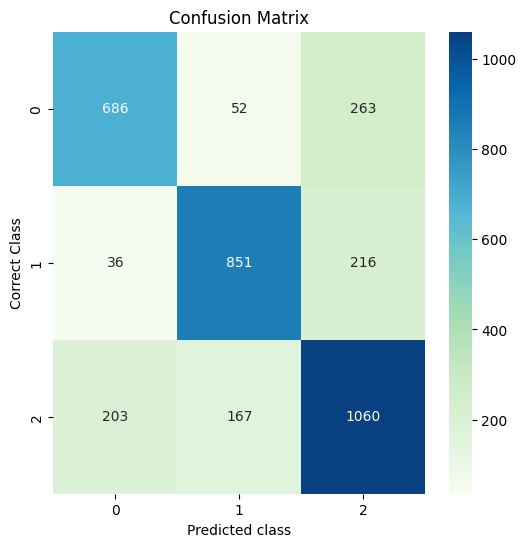

Accuracy:0.735
F1 Score: 0.735


In [83]:

from keras.models import load_model


model.save('model.h5')

loaded_model = load_model('model.h5')



accuracy,f1, fig = evaluate_lstm(loaded_model,X_val,Y_val)
print(f'Accuracy:{accuracy:.3f}')
print(f'F1 Score: {f1:.3f}')